### Code for Chapter 6: SCFT Numerics

Import some libraries.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
from scipy import integrate
from numba import autojit

Define some helper functions.

`get_fselector` defines which part of the copolymer sequence belongs to monomer type A (denoted by 1's) and which to type B (denoted by 0's). `sf` selects according to a head-to-tail perspective, while `sft` selects according to a tail-to-head perspective. These correspond to what the propagator functions q and qt 'see' as they 'walk' in their respective directions along the contour of the copolymer sequence. 

`get_k` gets the corresponding wavenumber/frequency grid.

`solve_phi` solves for the respective monomer densities according to eqn 5.47a and eqn 5.47b.

In [42]:
@autojit
def get_fselector(fa,fb,Ns):
    ka = int(fa*Ns)
    kb = int(fb*Ns)
    sf = np.concatenate((np.zeros(ka+1),np.ones(kb+1)),axis=0).astype(int)
    sft = np.concatenate((np.ones(kb+1),np.zeros(ka+1)),axis=0).astype(int)
    return sf,sft

def get_k(Nx):
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    kx, ky = np.meshgrid(freqs,freqs)
    k = kx + ky
    k2 = kx**2+ky**2
    return k2

@autojit
def solve_phi(q,qt,Nx,Na,ds,V):
    ax1 = np.linspace(0.,V,num=Nx)
    phi = np.zeros((Nx,Nx,2))
    for j in range(Nx):
        for k in range(Nx):
            # here is where the flipping of the backward propagator occurs.
            tmp1 = q[j,k,:]*qt[j,k,::-1]
            
            # eqn 5.47a and eqn 5.47b
            phi[j,k,0] = integrate.trapz(tmp1[:Na+1],dx=ds)
            phi[j,k,1] = integrate.trapz(tmp1[Na:],dx=ds)
    Q = 1./(V*V) * integrate.trapz(integrate.trapz(q[:,:,-1],x=ax1),x=ax1)

    return phi/Q

The main SCFT function. The algorithm of section 6.1.1 is referred to as simply 'the algorithm' here.

The modified diffusion equation is solved according to section 6.1.2: solving the MDE. Note that here, both the forward and backward propagator functions are updated and stored in the same direction, so a flipping of one of them will be necessary to account for the opposite directions (i.e. the head-tail perspectives).

In [37]:
def scft(Nx,fa,V,gam,XN,it,wisdom=None):
    # define spatial resolution (Nx) and number of monomers for each type.
    N = 20
    fb = 1.-fa
    Na = int(fa*N)
    Nb = int(fb*N)
    print('fa = %.1f' %fa)
    print('fb = %.1f' %fb)
    print('')

    # define copolymer sequence contour step-sizes (ds), and contour resolution (Ns).
    ds = 1./(N)
    Ns = int(N)

    # define time step-size (gamma_1 and gamma_2 of eqn 6.1a)
    eps = gam

    # define the Flory-Huggins parameter such that X_ab == constant always.
    Xab = XN/N
    
    # random seed for reproducibility.
    #np.random.seed(555)

    # initialize empty arrays and initial conditions.
    w = np.zeros((Nx,Nx,2))
    C = 0.1 # scaling factor
    w[:,:,:] = C*np.random.uniform(-1.,1.,(Nx,Nx,2))
    phi = np.zeros((Nx,Nx,2))
    q = np.zeros((Nx,Nx,Ns+1))
    qt = np.zeros((Nx,Nx,Ns+1))
    
    # import pyfftw wisdom if it is defined.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)
    
    # initialise pyfftw arrays.
    qpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    qppt = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    qp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    qpt = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    vt = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    
    # define pyfftw FFT plans.
    fft_object = pyfftw.FFTW(qpp, qp, threads=1, axes=(0,1))
    ifft_object = pyfftw.FFTW(qp, v, direction='FFTW_BACKWARD', threads=1, axes=(0,1))
    
    fft_object = pyfftw.FFTW(qppt, qpt, threads=1, axes=(0,1))
    ifft_object = pyfftw.FFTW(qpt, vt, direction='FFTW_BACKWARD', threads=1, axes=(0,1))

    # get the monomer configuration in the polymer.
    f, ft = get_fselector(fa,fb,Ns)

    # get wavenumber and spatial grid.
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    kx, ky = np.meshgrid(freqs,freqs)
    k = kx + ky
    k2 = kx**2+ky**2
    
    # get spatial grid.
    dx = np.linspace(0,V,num=Nx)

    # calculate xi and phi at first iteration. Step 1 of algorithm.
    pressure = (w[:,:,0] + w[:,:,1])/2
    pressure = pressure-pressure.mean()
    xi = Xab*N-pressure

    # calculate the initial phi values.
    phi[:,:,0] = (w[:,:,0] - xi)/(Xab*N)
    phi[:,:,1] = (w[:,:,1] - xi)/(Xab*N)

    # for each subsequent iteration...
    for i in xrange(it):
        # store the old phi values for equation 6.1c, step 4 of the algorithm.
        phi_old = np.copy(phi)

        # define initial conditions (eqn 5.30)
        q[:,:,0] = 1
        qt[:,:,0] = 1

        # solve the MDE.
        for s in xrange(1,Ns+1):
            # solving MDE: substep 1 (eqn 6.5a)
            qpp[:,:] = np.exp(-0.5*ds*w[:,:,f[s]])*q[:,:,s-1]
            qppt[:,:] = np.exp(-0.5*ds*w[:,:,ft[s]])*qt[:,:,s-1]
            
            # solving MDE: substep 2 (eqn 6.5b)
            qp[:,:] = np.exp(-4*np.pi**2*ds*k2/(V**2))*fft_object(qpp)
            qpt[:,:] = np.exp(-4*np.pi**2*ds*k2/(V**2))*fft_object(qppt)
            
            # solving MDE: substep 3 (eqn 6.5c)
            q[:,:,s] = np.exp(-0.5*ds*w[:,:,f[s]])*ifft_object(qp).real
            qt[:,:,s] = np.exp(-0.5*ds*w[:,:,ft[s]])*ifft_object(qpt).real
        
        # get the phi values using helper function.
        phi = solve_phi(q,qt,Nx,int(fa*Ns),ds,V)

        # get the pressure term (2nd term of xi, equation 5.47e).
        pressure = (w[:,:,0] + w[:,:,1])/2
        pressure = pressure-pressure.mean()

        # equation 6.1c.
        delta_phi = phi_old.sum(axis=2)-phi.sum(axis=2)
        delta_phi = delta_phi-delta_phi.mean()

        # update w(i) to w(i+1), equation 6.1a. This completes substep 4 of the algorithm.
        w[:,:,0] = w[:,:,0]+gam*(Xab*N*(phi[:,:,1]-0.5)+pressure-w[:,:,0])-eps*(delta_phi)
        w[:,:,1] = w[:,:,1]+gam*(Xab*N*(phi[:,:,0]-0.5)+pressure-w[:,:,1])-eps*(delta_phi)

        # print every 100th iteration.
        if i%100==0:
            print('it = %i' %i)
        
    wisdom = pyfftw.export_wisdom()

    return phi

Define parameters used and run the SCFT simulation.

In [39]:
# Nx = spatial resolution; fa = fraction of copolymer sequence belonging to monomer type A.
# gam = 'temporal' step-size (see eqn 6.1a)
# it = number of iterations; V = length of domain
# XN = Flory-Huggins parameter multiplied by the polymerisation index
Nx = 64
fa = 0.7
gam = 0.2
it = 1000
V = 6.
XN = 30.0

# run simulation.
phi = scft(Nx,fa,V,gam,XN,it)

fa = 0.7
fb = 0.3

it = 0
it = 50
it = 100
it = 150
it = 200
it = 250
it = 300
it = 350
it = 400
it = 450
it = 500
it = 550
it = 600
it = 650
it = 700
it = 750
it = 800
it = 850
it = 900
it = 950


Plot resulting morphology.

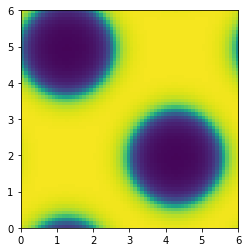

In [40]:
# calculate density difference
U = phi[:,:,0] - phi[:,:,1]

# plot.
fig = plt.figure()
plt.imshow(U ,origin='left',extent=[0,V,0,V], vmax=1.0, vmin=-1.0)
#plt.colorbar()
plt.show()

In [297]:
# output arrays of the monomer densities.
np.savetxt("phi0_fA=0.8_it=500.txt", phi[:,:,0])
np.savetxt("phi1_fA=0.8_it=500.txt", phi[:,:,1])